In [1]:
import random
import math
from os import mkdir
from os.path import join
import json
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import ttest_ind, norm
from itertools import combinations

In [2]:
SEED = 0
trials_exp = pd.read_csv('data/trials_exp.csv')
cluster_accuracy = pd.read_csv('data/cluster_accuracy.csv', index_col=0)
participant_ordering = pd.read_csv('data/participant_ordering.csv', index_col=0)

### Bootstrapped correlations

In [3]:
def splitAllParticipants(trials, i):
    half1 = trials.groupby(['participant_id', 'cluster']).sample(frac=0.5, replace=True, random_state=i)
    half2 = trials.drop(half1.index)
    halves = half1.groupby(['participant_id', 'cluster'])['accuracy'].mean().reset_index()\
                      .rename(columns={'accuracy':'half1'})
    halves['half2'] = half2.groupby(['participant_id', 'cluster'])[['accuracy']].mean().reset_index().accuracy
    #assert all((halves.groupby('participant_id')[['cluster']].nunique() == 
    #        len(remaining_clusters)).cluster.values)
    return halves

def calAvg(corrs):
    return np.tanh(np.mean(np.arctanh(corrs)))

def ind_diff(data, participant_pairs, all_pairs=False, sample_size=200):
    subjs = data.participant_id.unique()
    withinCorr, btwCorr = [], []
    if all_pairs:
        for i in range(len(subjs)):
            for j in range(len(subjs)):
                if i != j:
                    subj1 = data[data.participant_id == subjs[i]]
                    subj2 = data[data.participant_id == subjs[j]]
                    assert len(subj1) == len(subj2)
                    if i < j:
                        btwCorr.append(np.corrcoef(subj1.half1, subj2.half1)[0][1])
                        btwCorr.append(np.corrcoef(subj1.half2, subj2.half1)[0][1])
                    else:
                        btwCorr.append(np.corrcoef(subj1.half2, subj2.half2)[0][1])
                        btwCorr.append(np.corrcoef(subj1.half1, subj2.half2)[0][1])
                else:
                    thisSubj = data[data.participant_id == subjs[i]]
                    withinCorr.append(np.corrcoef(thisSubj.half1, thisSubj.half2)[0][1])
    else:
        withinCorr = data.groupby('participant_id').apply(lambda subj: np.corrcoef(subj.half1, subj.half2)[0][1])
        pair_idx = np.random.choice(len(participant_pairs), size=sample_size, replace=True)
        pairs = participant_pairs[pair_idx]
        btwCorr = []
        for i,j in pairs:
            subj1, subj2 = data.query("participant_id == @i"), data.query("participant_id == @j")
            assert len(subj1) == len(subj2)
            btwCorr.append(np.corrcoef(subj1.half1, subj2.half1)[0][1])
            btwCorr.append(np.corrcoef(subj1.half2, subj2.half1)[0][1])
            btwCorr.append(np.corrcoef(subj1.half2, subj2.half2)[0][1])
            btwCorr.append(np.corrcoef(subj1.half1, subj2.half2)[0][1])
    return withinCorr, btwCorr

def boot_ind_diff(trials,it=1000, pairs=None, all_pairs=False, sample_size=200):
    random.seed(SEED)
    np.random.seed(SEED)
    bootWithin, bootBtw = list(), list()
    for i in tqdm(range(it)):
        # use the iteration i as seed
        halves = splitAllParticipants(trials, i)
        withinSubj, btwSubj = ind_diff(halves, pairs, all_pairs=all_pairs, sample_size=sample_size)
        bootWithin.append(calAvg(withinSubj))
        bootBtw.append(calAvg(btwSubj))
    return bootWithin, bootBtw

### Permutation tests

In [4]:
def shuffle_cluster_labels(halves,coi):
    half_shuffled = []
    for subj in halves.participant_id.unique():
        tmp = np.random.choice(halves[halves.participant_id== subj][coi],
                                sum(halves.participant_id== subj),False)
        half_shuffled.append(tmp)
    
    return np.concatenate(half_shuffled)

def permutation_test(trials, groups, it=1000, all_pairs=False, sample_size=200):
    random.seed(SEED)
    np.random.seed(SEED)
    within_list, btw_list, within_perm_list, btw_perm_list = [], [], [], []
    if len(groups) == 1:
        results = {'within': {'all': []}, 
                   'between': {'all': []},
                   'within_perm': {'all': []},
                    'between_perm': {'all': []}}
    else:
        results = {
            'within': {'high': [], 'low': []},
            'between': {'high': [], 'low': []},
            'within_perm': {'high': [], 'low': []},
            'between_perm': {'high': [], 'low': []}
        }
    for i in tqdm(range(it)):
        halves = splitAllParticipants(trials, i)
        halves_shuffled = pd.DataFrame()
        halves_shuffled['half1'] = shuffle_cluster_labels(halves,'half1')
        halves_shuffled['half2'] = shuffle_cluster_labels(halves,'half2')
        halves_shuffled.index = halves.index
        halves_shuffled['participant_id'] = halves['participant_id']

        for group_ids, group_pairs, group in groups:
            group_halves = halves[halves.participant_id.isin(group_ids)]
            within, btw = ind_diff(group_halves, group_pairs, all_pairs=all_pairs, sample_size=sample_size)
            results['within'][group].append(calAvg(within))
            results['between'][group].append(calAvg(btw))

            group_halves_perm = halves_shuffled[halves_shuffled.participant_id.isin(group_ids)]
            within_perm, btw_perm = ind_diff(group_halves_perm, group_pairs, all_pairs=all_pairs, sample_size=sample_size)
            results['within_perm'][group].append(calAvg(within_perm))
            results['between_perm'][group].append(calAvg(btw_perm))
            #print(np.mean(results['within'][group]))
    new_dict = {(outerKey, innerKey): values for outerKey, innerDict in results.items()\
                                            for innerKey, values in innerDict.items()}
    return pd.DataFrame(new_dict)

## Analysis 1: all participants' correlations

Test 1: within and between significance, bootstrap test for p-value, report permutation correlations 97.5 percentile

In [58]:
participant_ids = trials_exp.participant_id.unique()
participant_pairs = np.array(list(combinations(participant_ids, 2)))

group = [(participant_ids, participant_pairs, 'all')]
perm_result = permutation_test(trials_exp, group, it=1000, all_pairs=False, sample_size=200)
perm_df = perm_result.droplevel(level=-1, axis=1)

#bootWithin, bootBtw = boot_ind_diff(trials_exp, it=500, pairs=participant_pairs)
#bootResults = pd.DataFrame(np.asarray([bootWithin, bootBtw]).T, columns=['within', 'between'])

100%|███████████████████████████████████████| 1000/1000 [39:30<00:00,  2.37s/it]


In [5]:
#perm_df.to_csv("perm_df_test1_all.csv", index=False)
perm_df = pd.read_csv("perm_df_test1_all.csv")

In [7]:
print("1. Show that Within and Between correlations are significant")
#print('bootstrap test:',2*np.mean((np.array(bootResults.within)-np.array(bootResults.between))<0))
p1_w = np.mean(perm_df.within < perm_df.within_perm)
p1_b = np.mean(perm_df.between < perm_df.between_perm)
print('Permutation test, p-value:', p1_w, p1_b)

print("Permutation test 97.5% confidence interval upper bound")
print(f"Within: {np.percentile(perm_df.within_perm, 97.5):.3f}")
print(f"Between: {np.percentile(perm_df.between_perm, 97.5):.3f}")

perm_within = np.percentile(perm_df.within_perm, 97.5)
perm_between = np.percentile(perm_df.between_perm, 97.5)

1. Show that Within and Between correlations are significant
Permutation test, p-value: 0.0 0.0
Permutation test 97.5% confidence interval upper bound
Within: 0.022
Between: 0.007


In [8]:
print('2. Show that Within are higher than Between correlations')
p2 = np.mean((perm_df.within - perm_df.between) < (perm_df.within_perm - perm_df.between_perm))
print('Permutation test, p-value:', p2)

2. Show that Within are higher than Between correlations
Permutation test, p-value: 0.0


In [9]:
np.mean(perm_df.between.values)

0.6204909919827617

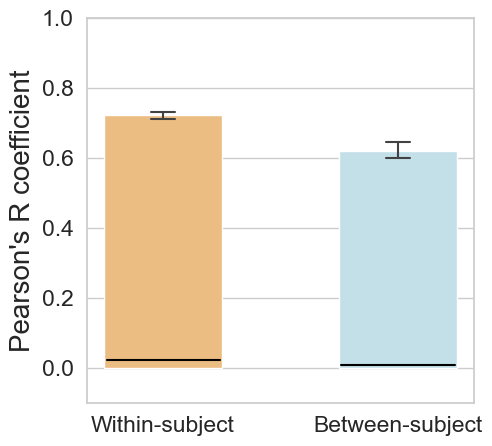

In [10]:
sns.set(font_scale=1.5)
plt.figure(figsize=(5,5))

with sns.axes_style("whitegrid"):
    width = 0.5
    within = pd.DataFrame(data=perm_df.within.values, columns=['correlation'])
    within['measure'] = 'Within-subject'
    between = pd.DataFrame(data=perm_df.between.values, columns=['correlation'])
    between['measure'] = 'Between-subject'
    df = pd.concat((within, between), axis=0)

    fig = sns.barplot(df,x='measure', y='correlation', errorbar='pi', errwidth=1.5,
                capsize=0.1, alpha=1, palette='RdYlBu', width=width) #RdYlBu
    plt.ylim([-0.1, 1])
    
    x = np.array([0,1])
    plt.plot([x - width/2 + 0.01,x + width/2 - 0.005],\
                np.asarray([[perm_within, perm_within],
                 [perm_between,perm_between]]).T,\
                color='black')
    #plt.plot([x  + 0.01,x + width/2  - 0.01],\
    #        np.asarray([[perm_within_low,perm_within_low],
    #         [perm_between_low,perm_between_low]]).T,\
    #        color='black')
    #fig.set_yticklabels(fig.get_xticks(), size = 16)
    plt.ylabel("Pearson's R coefficient", fontsize=20)
    plt.xlabel("", fontsize=20)
    plt.savefig("all_test1.svg", bbox_inches='tight', dpi=300)
    plt.show()

## Analysis 2: Compare high and low performance groups

In [44]:
# Create two groups with incrementing size
half_idx = len(participant_ordering) // 2
low_group_ids, high_group_ids = participant_ordering.index[:half_idx], participant_ordering.index[-half_idx:]
# Assert no participant in both groups
assert not set(low_group_ids).intersection(high_group_ids)

low_group_pairs = np.array(list(combinations(low_group_ids, 2)))
high_group_pairs = np.array(list(combinations(high_group_ids, 2)))
groups = [(low_group_ids, low_group_pairs, 'low'), (high_group_ids, high_group_pairs, 'high')]

In [12]:
exp_folder = f"data/exp_iqr_1000it"
#mkdir(exp_folder)
#mkdir(join(exp_folder,'df'))
#mkdir(join(exp_folder,'p_values'))

Test 2.5: Within for high is higher than within for low
np.mean(perm_df.within.high - perm_df.within.low < perm_df.within_perm.high - perm_df.within_perm.low)

In [49]:
perm_filename = f'{exp_folder}/df/df_cluster_0.49.csv'
perm_df = pd.read_csv(perm_filename, header=[0,1])#[['within', 'between']]

In [50]:
p1_w = np.mean(perm_df.within.high < perm_df.within_perm.high)
p1_b = np.mean(perm_df.between.high < perm_df.between_perm.high)
print(f"\t1. High within: {p1_w} - between: {p1_b}")

p1_w = np.mean(perm_df.within.low < perm_df.within_perm.low)
p1_b = np.mean(perm_df.between.low < perm_df.between_perm.low)
print(f"\t1. Low within: {p1_w} - between: {p1_b}")

p_high = np.mean((perm_df.within.high - perm_df.between.high) < 
                     (perm_df.within_perm.high - perm_df.between_perm.high))
p_low = np.mean((perm_df.within.low - perm_df.between.low) < 
                (perm_df.within_perm.low - perm_df.between_perm.low))
print(f"\t2. high: {p_high} - low: {p_low}")

p25_w = np.mean(perm_df.within.high - perm_df.within.low < perm_df.within_perm.high - perm_df.within_perm.low)
p25_b = np.mean(perm_df.between.high - perm_df.between.low < perm_df.between_perm.high - perm_df.between_perm.low)
p25_b_r = np.mean(perm_df.between.low - perm_df.between.high < perm_df.between_perm.low - perm_df.between_perm.high)
print(f"\t2.5 within: {p25_w} - between high>low: {p25_b} - between high<low: {p25_b_r}")

diff_high = abs(perm_df.within.high - perm_df.between.high)
diff_low = abs(perm_df.within.low - perm_df.between.low)
diff_high_perm = abs(perm_df.within_perm.high - perm_df.between_perm.high)
diff_low_perm = abs(perm_df.within_perm.low - perm_df.between_perm.low)

p = np.mean((diff_high - diff_low) < (diff_high_perm - diff_low_perm))
print(p)

	1. High within: 0.0 - between: 0.0
	1. Low within: 0.0 - between: 0.0
	2. high: 0.0 - low: 0.046
	2.5 within: 0.072 - between high>low: 0.996 - between high<low: 0.004
0.0


In [51]:
print("Permutation test 97.5% confidence interval upper bound")
print(f"High within: {np.percentile(perm_df.within_perm.high, 97.5):.3f}")
print(f"High between: {np.percentile(perm_df.between_perm.high, 97.5):.3f}")
print(f"Low within: {np.percentile(perm_df.within_perm.low, 97.5):.3f}")
print(f"Low between: {np.percentile(perm_df.between_perm.low, 97.5):.3f}")

perm_within_high = np.percentile(perm_df.within_perm.high, 97.5)
perm_between_high = np.percentile(perm_df.between_perm.high, 97.5)
perm_within_low = np.percentile(perm_df.within_perm.low, 97.5)
perm_between_low = np.percentile(perm_df.between_perm.low, 97.5)

Permutation test 97.5% confidence interval upper bound
High within: 0.081
High between: 0.018
Low within: 0.077
Low between: 0.020


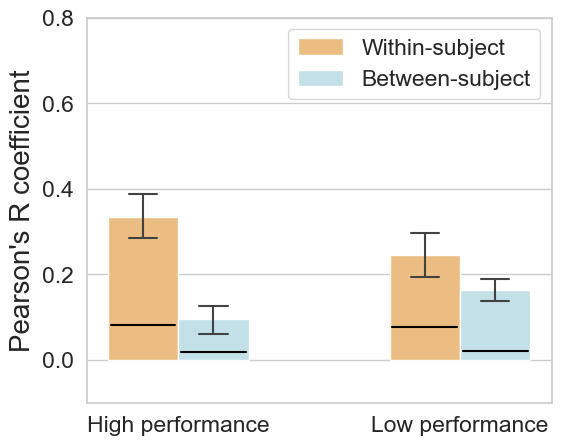

In [54]:
sns.set(font_scale=1.5)
plt.figure(figsize=(6,5))

with sns.axes_style("whitegrid"):
    #within = pd.DataFrame(data=perm_df.within.values, columns=['correlation'])
    #within['measure'] = 'Within-subject'
    #between = pd.DataFrame(data=perm_df.between.values, columns=['correlation'])
    #between['measure'] = 'Between-subject'
    #df = pd.concat((within, between), axis=0)
    width = 0.5
    df = pd.melt(perm_df[['within', 'between']], var_name=['type', 'group'], value_name='correlation')
    df = df.replace({'within':'Within-subject', 'between': 'Between-subject', 'high':'High performance', 'low':'Low performance'})

    fig = sns.barplot(df,x='group', y='correlation', hue='type', errorbar='pi', errwidth=1.5,
                capsize=0.1, alpha=1, palette='RdYlBu', width=width) #RdYlBu
    #plt.axhline(y=0.018)
    plt.ylim([-0.1, 0.8])
    x = np.array([0,1])
    plt.plot([x - width/2 + 0.01,x - 0.01],\
                np.asarray([[perm_within_high, perm_within_high], [perm_within_low,perm_within_low]]).T,\
                color='black')
    plt.plot([x  + 0.01,x + width/2  - 0.01],\
            np.asarray([[perm_between_high,perm_between_high],
             [perm_between_low,perm_between_low]]).T,\
            color='black')
    plt.legend(title='')
    #fig.get_legend().remove()
    #fig.set_yticklabels(fig.get_xticks(), size = 16)
    plt.ylabel("Pearson's R coefficient", fontsize=20)
    plt.xlabel("", fontsize=20)
    plt.savefig("group_test1_std49_xlim.svg", bbox_inches='tight', dpi=300)
    plt.show()

In [24]:
std_values = [0.49, 0.475, 0.45, 0.425, 0.4, 0.375, 0.35, 
                   0.325, 0.3, 0.275, 0.25, 0.225, 0.2, 0.175]

Std threshold 0.49 - Remaining clusters 20


100%|█████████████████████████████████████████████████| 1000/1000 [54:33<00:00,  3.27s/it]


	2. high: 0.00 - low: 0.05
	3. p-value 0.00


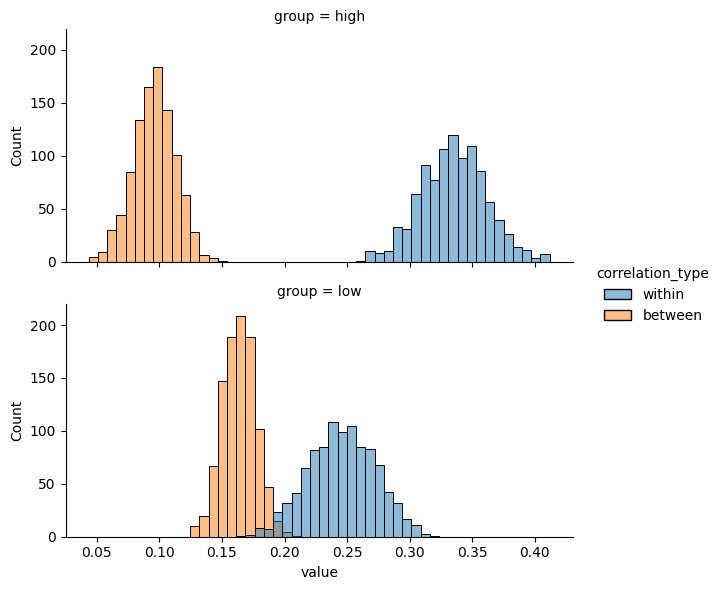

Std threshold 0.475 - Remaining clusters 31


100%|█████████████████████████████████████████████████| 1000/1000 [50:54<00:00,  3.05s/it]


	2. high: 0.00 - low: 0.02
	3. p-value 0.00


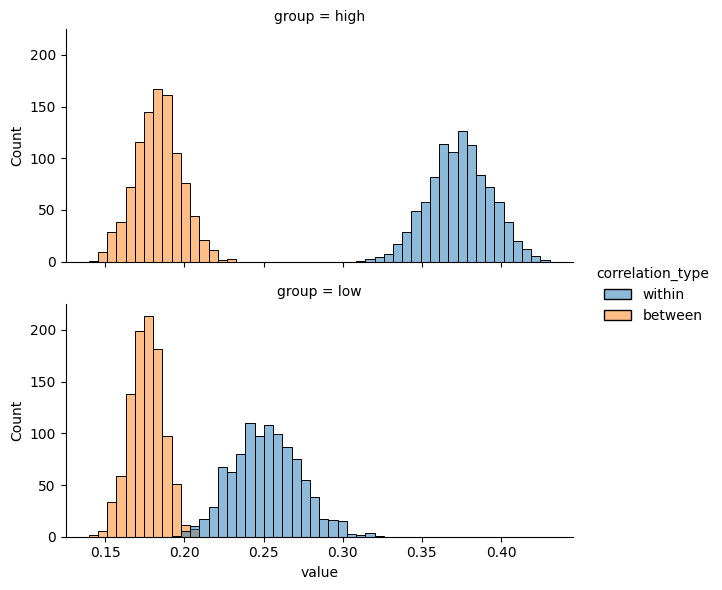

Std threshold 0.45 - Remaining clusters 41


100%|█████████████████████████████████████████████████| 1000/1000 [44:38<00:00,  2.68s/it]


	2. high: 0.00 - low: 0.01
	3. p-value 0.00


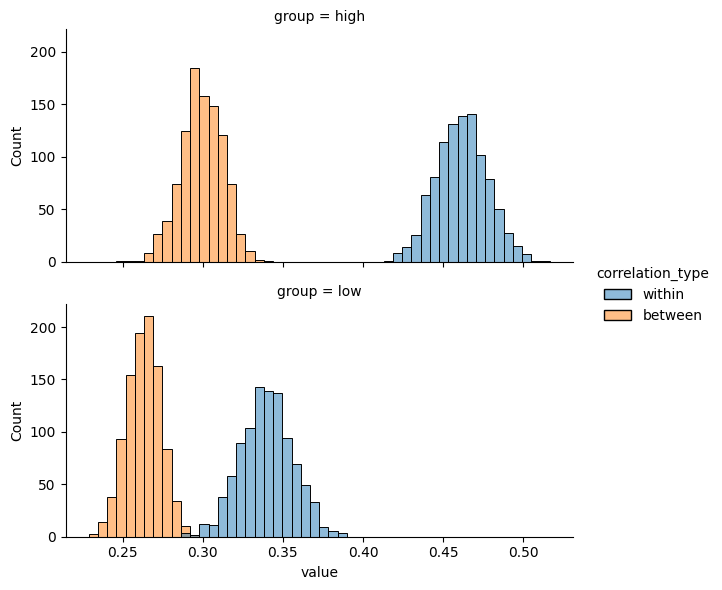

Std threshold 0.425 - Remaining clusters 41


100%|█████████████████████████████████████████████████| 1000/1000 [44:10<00:00,  2.65s/it]


	2. high: 0.00 - low: 0.01
	3. p-value 0.00


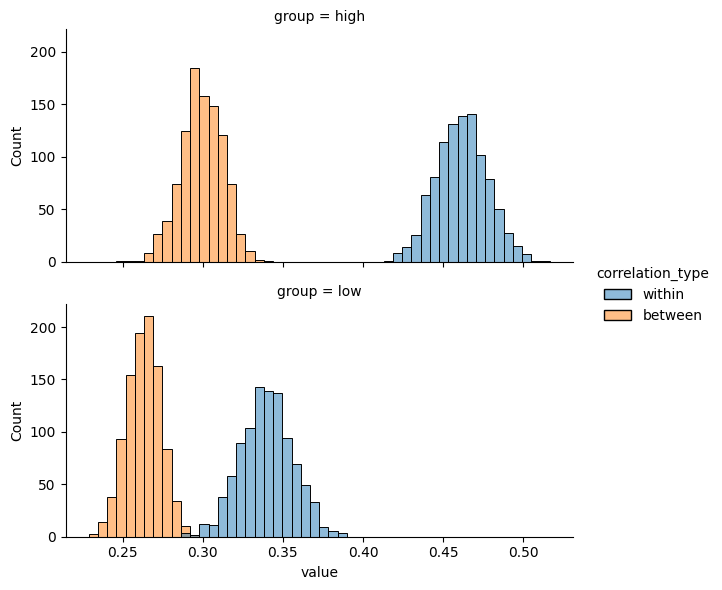

Std threshold 0.4 - Remaining clusters 44


100%|█████████████████████████████████████████████████| 1000/1000 [45:36<00:00,  2.74s/it]


	2. high: 0.00 - low: 0.00
	3. p-value 0.01


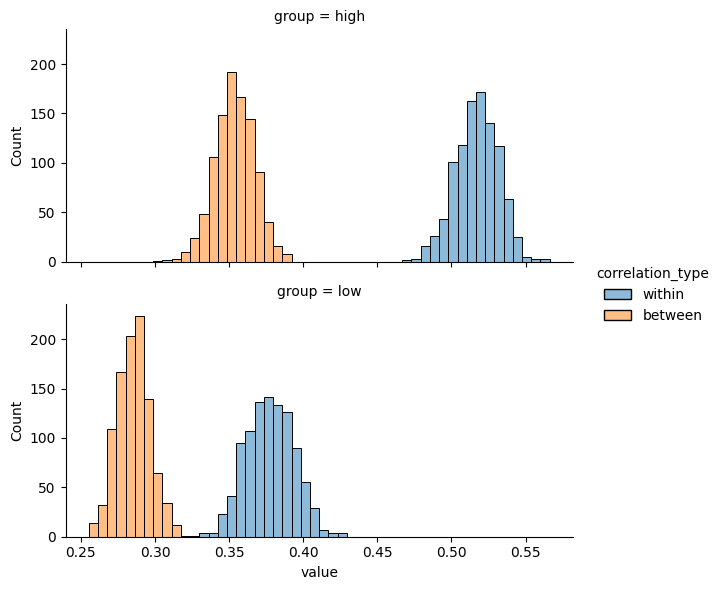

Std threshold 0.375 - Remaining clusters 48


100%|█████████████████████████████████████████████████| 1000/1000 [46:06<00:00,  2.77s/it]


	2. high: 0.00 - low: 0.00
	3. p-value 0.08


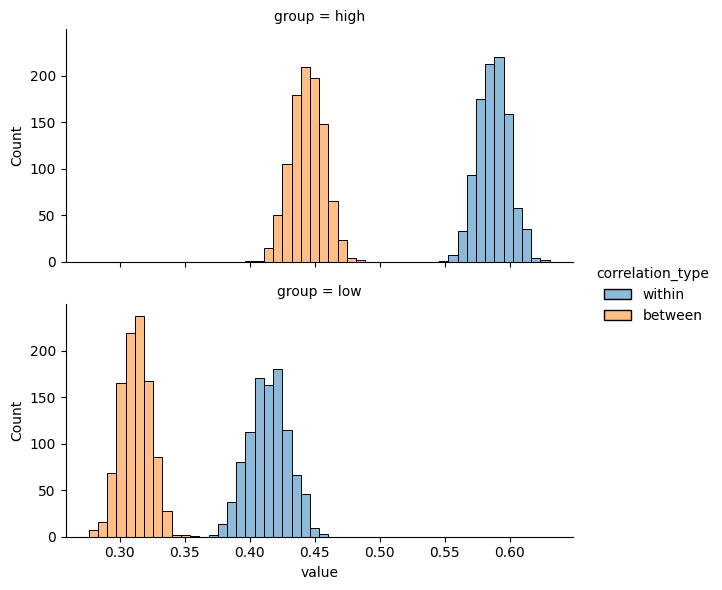

Std threshold 0.35 - Remaining clusters 54


100%|█████████████████████████████████████████████████| 1000/1000 [46:58<00:00,  2.82s/it]


	2. high: 0.00 - low: 0.00
	3. p-value 0.20


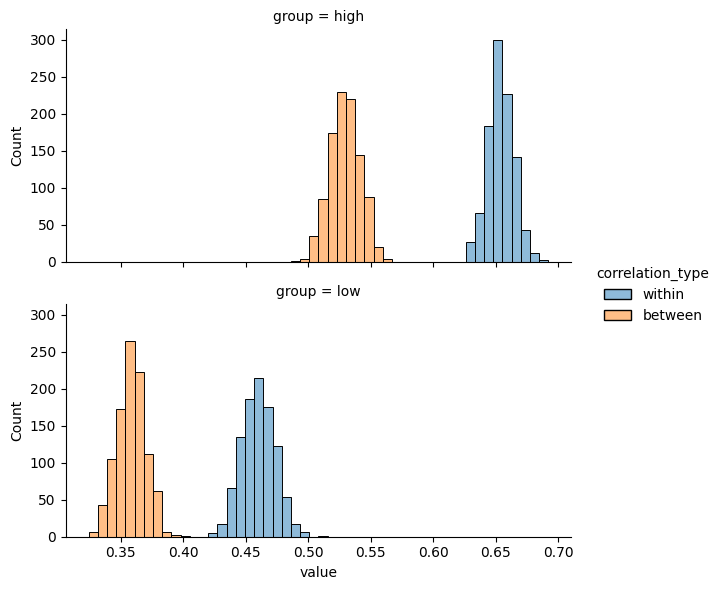

Std threshold 0.325 - Remaining clusters 61


100%|█████████████████████████████████████████████████| 1000/1000 [48:45<00:00,  2.93s/it]


	2. high: 0.00 - low: 0.00
	3. p-value 0.43


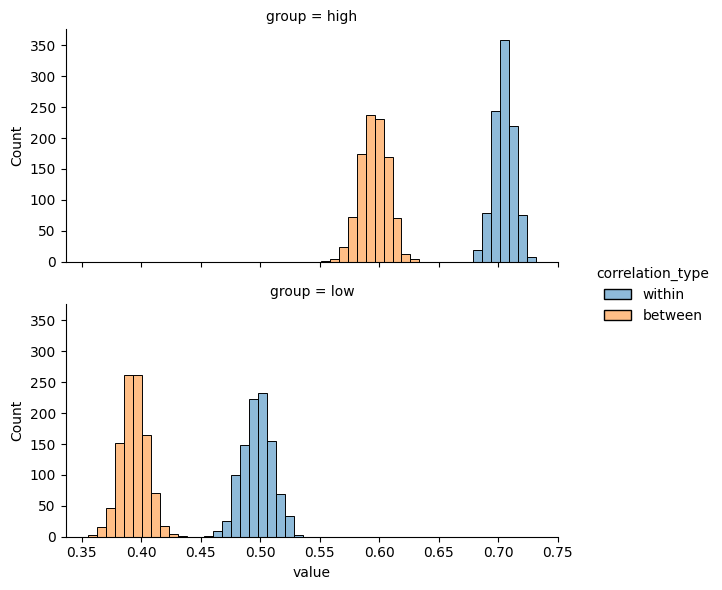

Std threshold 0.3 - Remaining clusters 68


100%|█████████████████████████████████████████████████| 1000/1000 [50:08<00:00,  3.01s/it]


	2. high: 0.00 - low: 0.00
	3. p-value 0.54


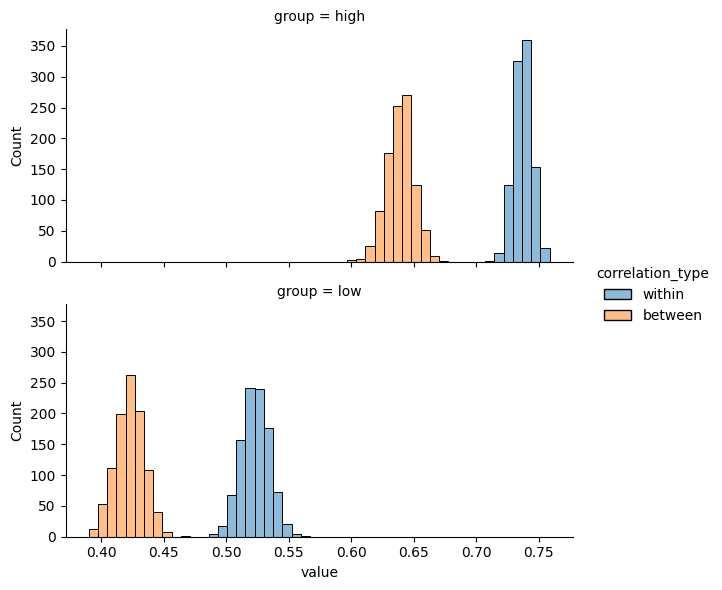

Std threshold 0.275 - Remaining clusters 78


100%|█████████████████████████████████████████████████| 1000/1000 [50:57<00:00,  3.06s/it]


	2. high: 0.00 - low: 0.00
	3. p-value 0.61


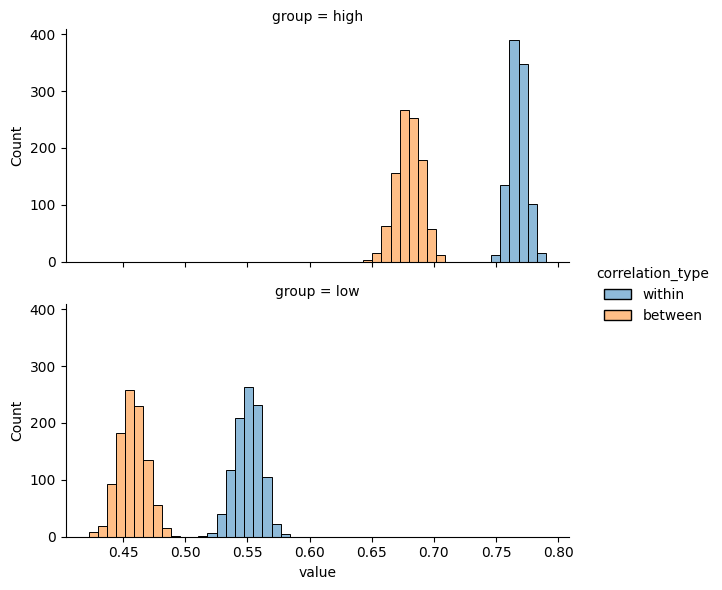

Std threshold 0.25 - Remaining clusters 87


100%|█████████████████████████████████████████████████| 1000/1000 [52:05<00:00,  3.13s/it]


	2. high: 0.00 - low: 0.00
	3. p-value 0.65


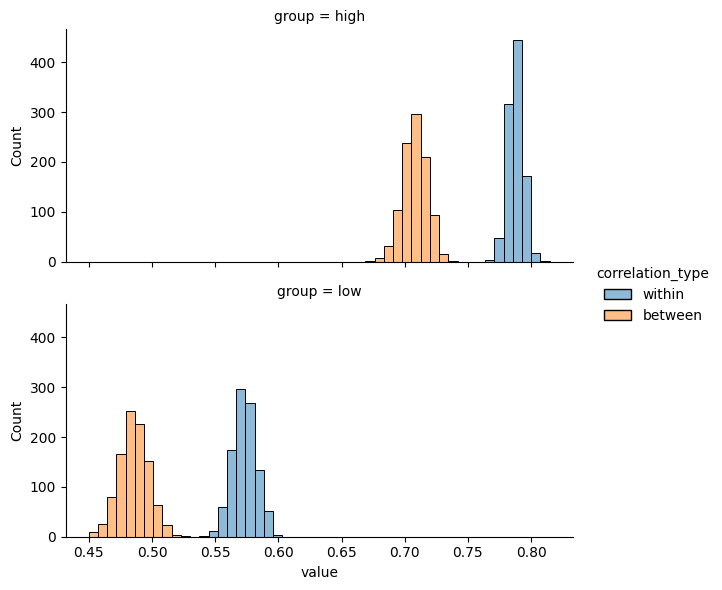

Std threshold 0.225 - Remaining clusters 92


100%|█████████████████████████████████████████████████| 1000/1000 [52:57<00:00,  3.18s/it]


	2. high: 0.00 - low: 0.00
	3. p-value 0.61


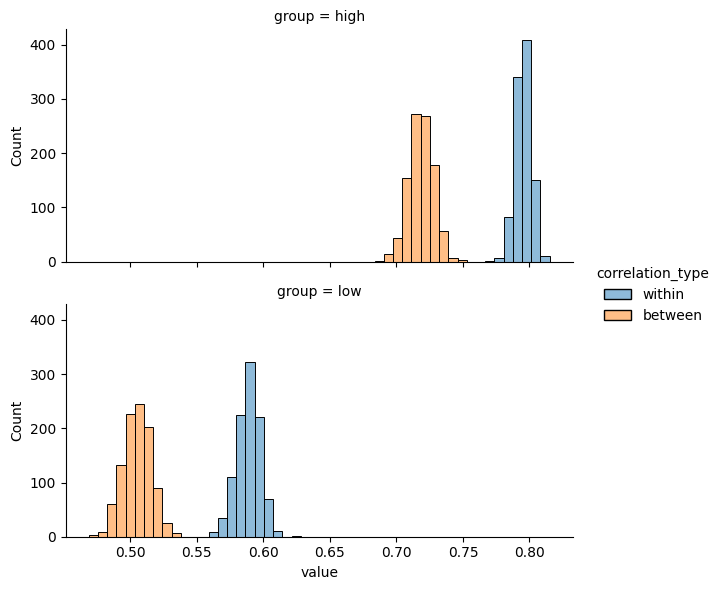

Std threshold 0.2 - Remaining clusters 96


100%|█████████████████████████████████████████████████| 1000/1000 [53:44<00:00,  3.22s/it]


	2. high: 0.00 - low: 0.00
	3. p-value 0.61


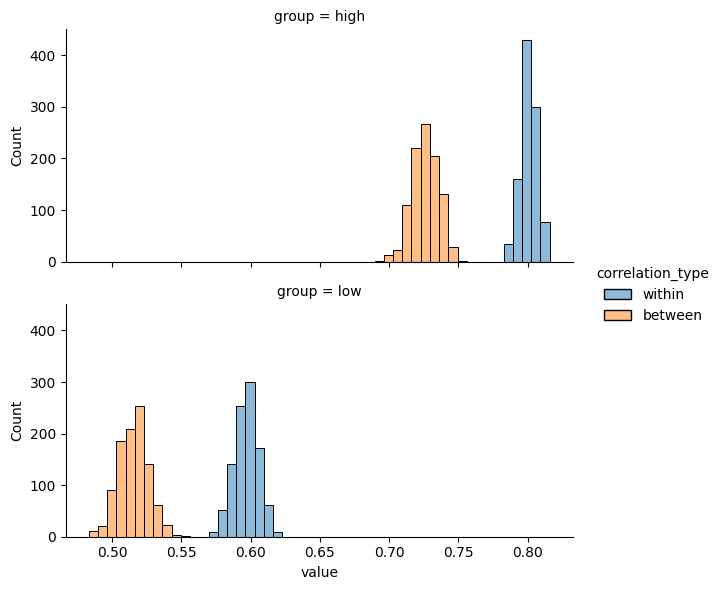

Std threshold 0.175 - Remaining clusters 100


100%|█████████████████████████████████████████████████| 1000/1000 [54:07<00:00,  3.25s/it]


	2. high: 0.00 - low: 0.00
	3. p-value 0.64


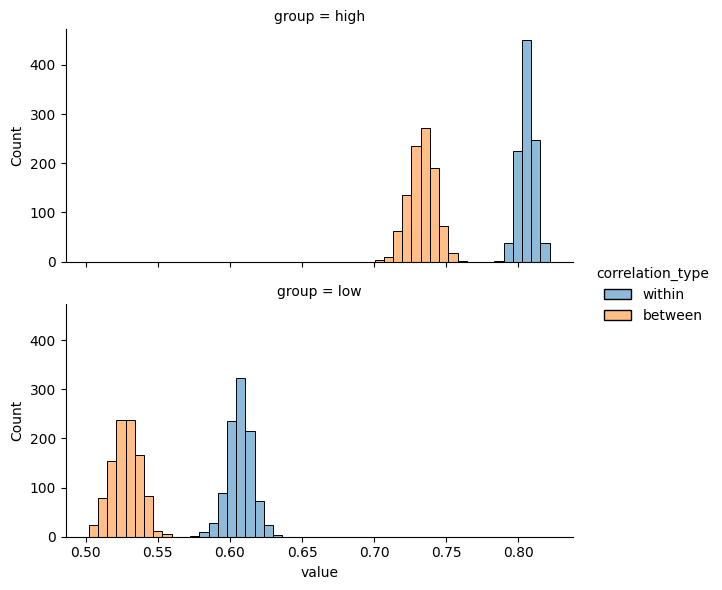

In [21]:
for std_thresh in std_values:
    perm_filename = f'{exp_folder}/df/df_cluster_{std_thresh}.csv'
    p_value_filename = f'{exp_folder}/p_values/p_values_{std_thresh}.json'
    
    remaining_clusters = cluster_accuracy.query('std >= @std_thresh').index
    trials_final = trials_exp[trials_exp.cluster.isin(remaining_clusters)].copy()
    print(f'Std threshold {std_thresh} - Remaining clusters {len(remaining_clusters)}')
    
    assert trials_final.participant_id.nunique() == trials_exp.participant_id.nunique()
    assert trials_final[trials_final.participant_id.isin(low_group_ids)].accuracy.mean() <=\
            trials_final[trials_final.participant_id.isin(high_group_ids)].accuracy.mean()
    
    perm_df = permutation_test(trials_final, groups, it=1000, all_pairs=False, sample_size=200)
    perm_df.to_csv(perm_filename, index=False)
    
    simple_df = pd.DataFrame({
        'within': np.concatenate((perm_df.within.high, perm_df.within.low)),
        'between': np.concatenate((perm_df.between.high, perm_df.between.low)),
        'within_perm': np.concatenate((perm_df.within_perm.high, perm_df.within_perm.low)),
        'between_perm': np.concatenate((perm_df.between_perm.high, perm_df.between_perm.low)),
     })
    
    p_values = {
        2: {'high': [], 'low': []},
        3: []
    }
    
    p_high = np.mean((perm_df.within.high - perm_df.between.high) < 
                     (perm_df.within_perm.high - perm_df.between_perm.high))
    p_low = np.mean((perm_df.within.low - perm_df.between.low) < 
                    (perm_df.within_perm.low - perm_df.between_perm.low))
    p_values[2]['high'].append(p_high)
    p_values[2]['low'].append(p_low)
    
    print(f"\t2. high: {p_high:.2f} - low: {p_low:.2f}")

    diff_high = abs(perm_df.within.high - perm_df.between.high)
    diff_low = abs(perm_df.within.low - perm_df.between.low)
    diff_high_perm = abs(perm_df.within_perm.high - perm_df.between_perm.high)
    diff_low_perm = abs(perm_df.within_perm.low - perm_df.between_perm.low)

    p = np.mean((diff_high - diff_low) < (diff_high_perm - diff_low_perm))
    p_values[3].append(p)
    print(f'\t3. p-value {p:.2f}')
    with open(p_value_filename, 'w') as f:
        json.dump(p_values, f)
        
    all_boot_results = pd.melt(perm_df[['within', 'between']], var_name=['correlation_type', 'group'])
    sns.displot(all_boot_results, x='value', hue='correlation_type', row='group', bins=50, height=3, aspect=2)
    plt.show()

### Visualizations

In [17]:
all_df = []
for std_thresh in std_values:
#    std_thresh = 0.49
    df = pd.read_csv(f'{exp_folder}/df/df_cluster_{std_thresh}.csv', header=[0,1])

    all_boot_results = pd.melt(df[['within', 'between']], var_name=['correlation_type', 'group'])
    #sns.displot(all_boot_results, x='value', hue='correlation_type', row='group', 
    #            bins=30, height=3, aspect=2, lw=0.5)
    #plt.xlim([0.05, 0.85])
    #print(std_thresh)
    #plt.show()
    all_boot_results['std_thresh'] = std_thresh
    all_df.append(all_boot_results)
all_df = pd.concat(all_df)

In [18]:
all_df

,correlation_type,group,value,std_thresh
0,within,high,0.302888,0.49
1,within,high,0.299596,0.49
2,within,high,0.310823,0.49
3,within,high,0.346749,0.49
4,within,high,0.327180,0.49
...,...,...,...,...
1995,between,low,0.504448,0.10
1996,between,low,0.496756,0.10
1997,between,low,0.485658,0.10
1998,between,low,0.486291,0.10


In [37]:
all_df['type'] = all_df.group + '_' + all_df.correlation_type

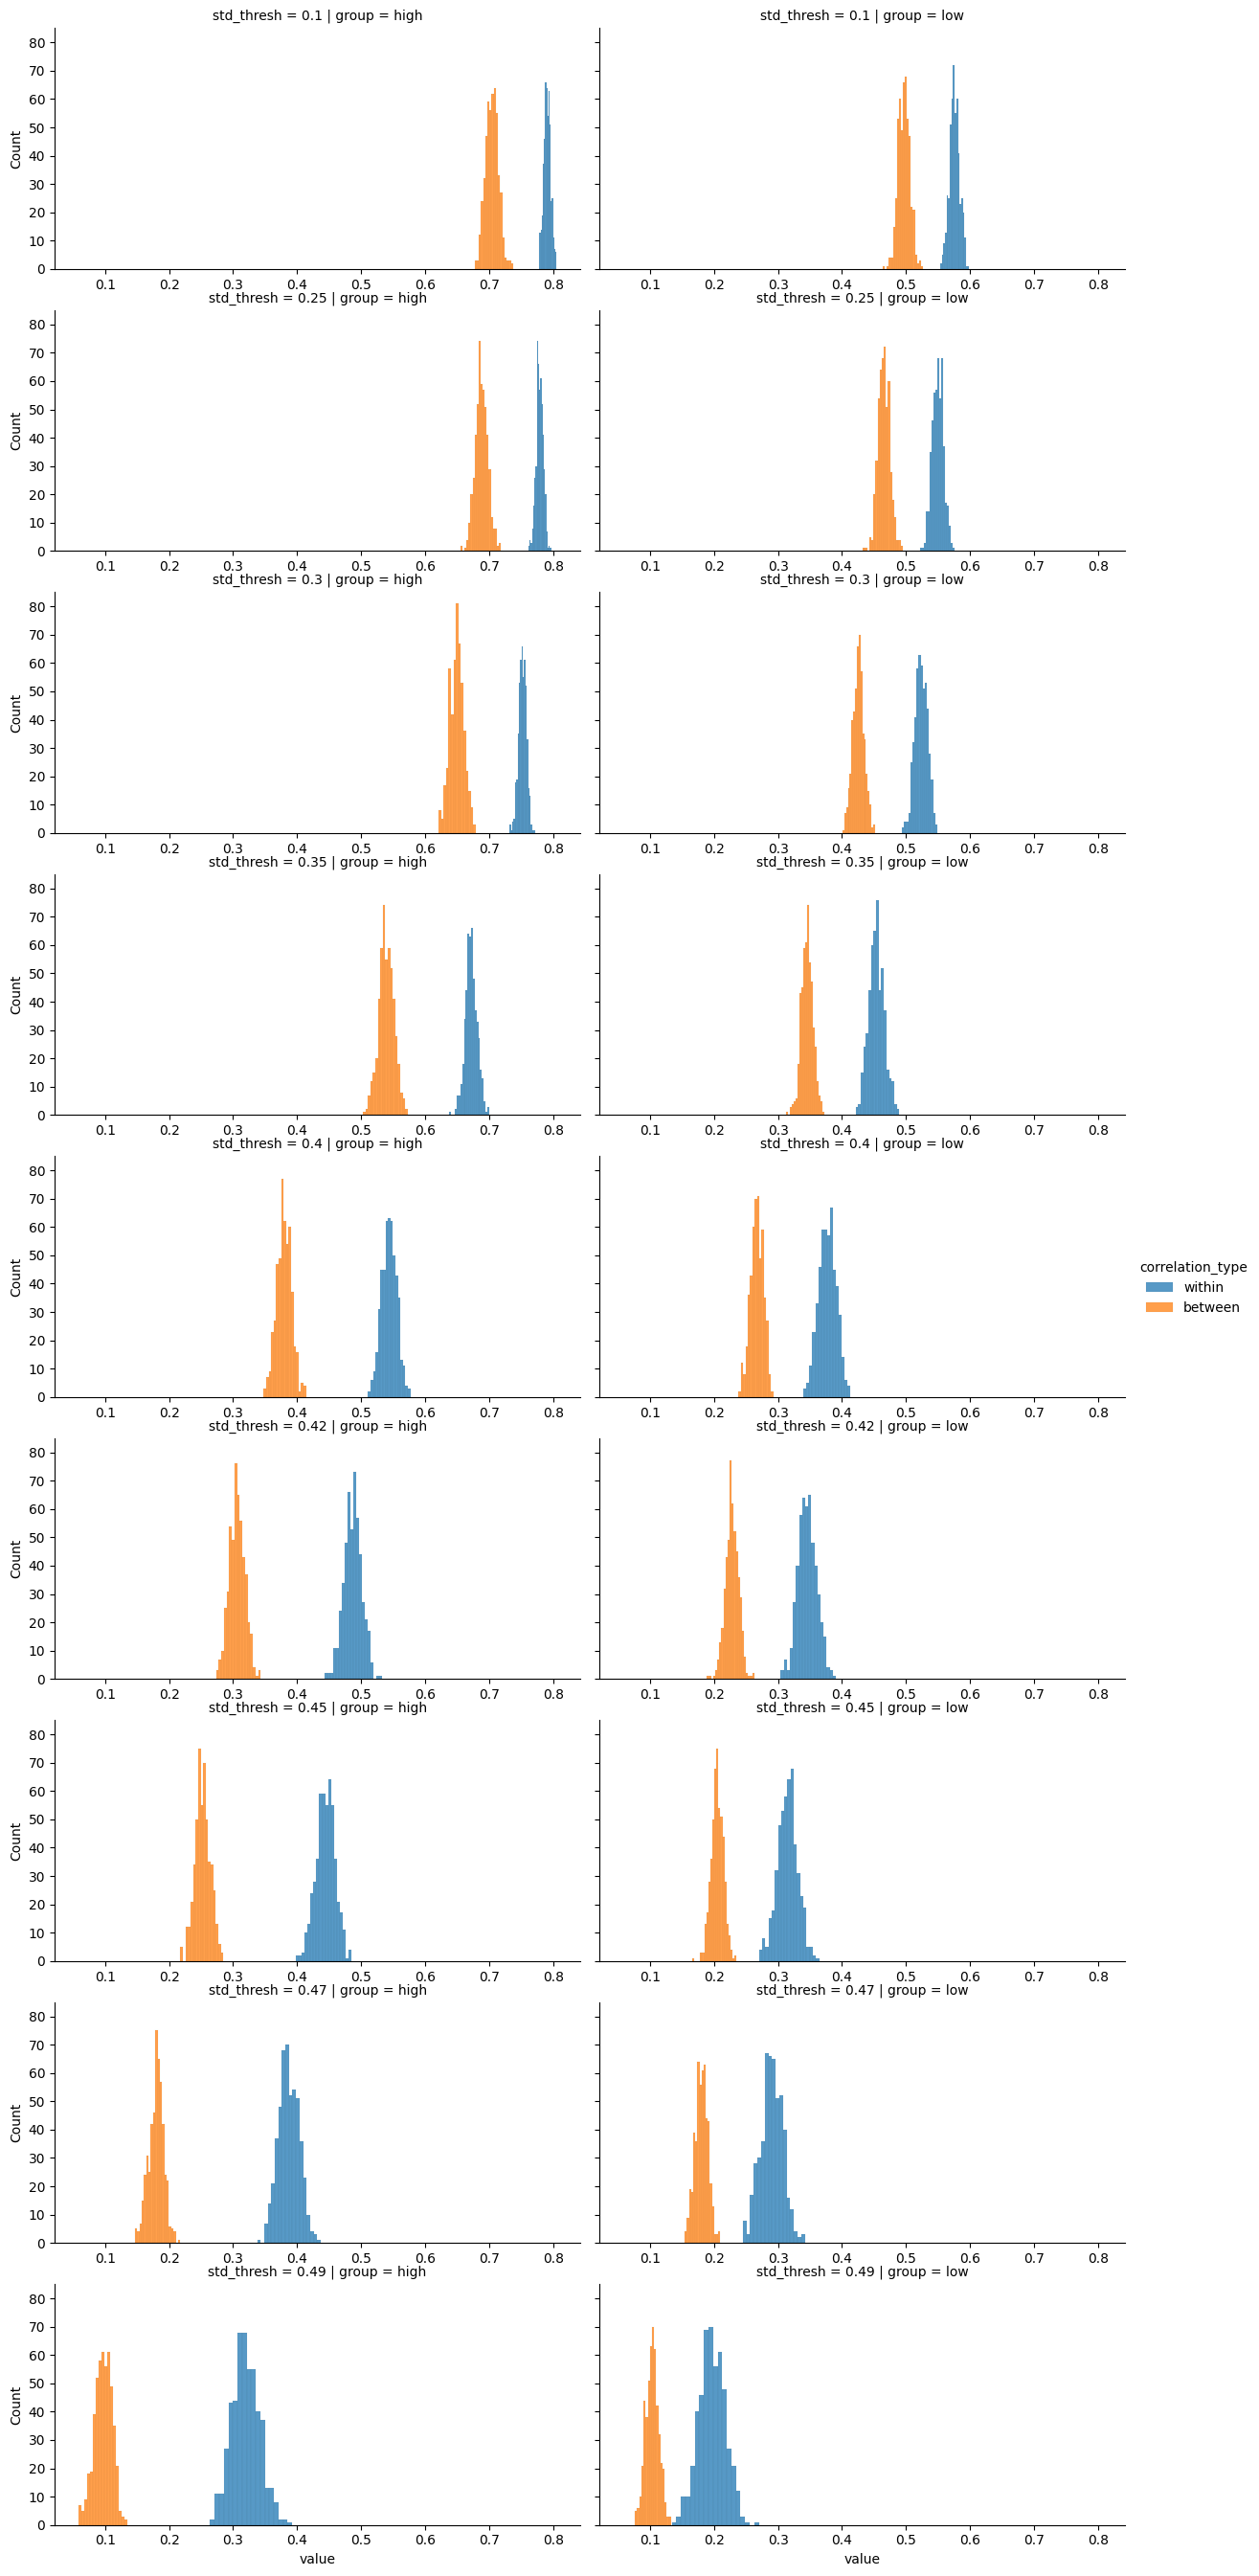

In [21]:
g = sns.FacetGrid(all_df, col='group', row='std_thresh', hue='correlation_type', aspect=2)
p1 = g.map(sns.histplot, 'value', lw=0.02).add_legend()
for axis in g.axes.flat:
    axis.tick_params(labelbottom=True)

In [25]:
dfs = []
for std_thresh in std_values:
#    std_thresh = 0.49
    df = pd.read_csv(f'{exp_folder}/df/df_cluster_{std_thresh}.csv', header=[0,1])
    tmp_df = pd.DataFrame()
    tmp_df['dd'] = (df.within.high - df.between.high).abs() - (df.within.low - df.between.low).abs()
    #tmp_df['significance'] = np.where(tmp_df.std_threshold >= 0.4, 'solid', 'dashed')
    tmp_df['boot_diff'] = (df.within.high - df.between.high).abs()
    tmp_df['perm_diff'] =  (df.within.low - df.between.low).abs()
    tmp_df['std_threshold'] = std_thresh
    dfs.append(tmp_df)
dd_df = pd.concat(dfs)

In [26]:
dd_plot = pd.melt(dd_df, value_vars=['boot_diff', 'perm_diff'], id_vars=['std_threshold'], var_name='type', value_name='idiosyncracy')
#dd_plot['std_threshold'].replace({0.1: round(min_std,2)}, inplace=True)

In [12]:
pal = sns.color_palette('RdYlBu')
print(pal.as_hex()[:])
pal.as_hex()

['#e34933', '#fca55d', '#fee99d', '#e9f6e8', '#a3d3e6', '#588cc0']


['#e34933', '#fca55d', '#fee99d', '#e9f6e8', '#a3d3e6', '#588cc0']

In [27]:
cluster_accuracy.query('std > @std_thresh').acc.mean()

0.7581041704209612

In [28]:
hist_data = []
acc_data = []
for std_thresh in std_values:
    acc_data.append([std_thresh, cluster_accuracy.query('std > @std_thresh').acc.mean()])
    hist_data.append([std_thresh, len(cluster_accuracy.query('std > @std_thresh'))])

acc_df = pd.DataFrame(acc_data, columns=['std_thresh', 'acc'])
hist_df = pd.DataFrame(hist_data, columns=['std_thresh', 'count'])
hist_df

,std_thresh,count
0,0.490,20
1,0.475,31
2,0.450,41
3,0.425,41
4,0.400,44
5,0.375,48
6,0.350,54
7,0.325,61
8,0.300,68
9,0.275,78


In [29]:
unsignificant = dd_plot.query("std_threshold <= 0.425")
significant = dd_plot.query("std_threshold >= 0.425")

In [30]:
significant

,std_threshold,type,idiosyncracy
0,0.490,boot_diff,0.253139
1,0.490,boot_diff,0.298595
2,0.490,boot_diff,0.216503
3,0.490,boot_diff,0.242930
4,0.490,boot_diff,0.271771
...,...,...,...
17995,0.425,perm_diff,0.085938
17996,0.425,perm_diff,0.083646
17997,0.425,perm_diff,0.076727
17998,0.425,perm_diff,0.062482


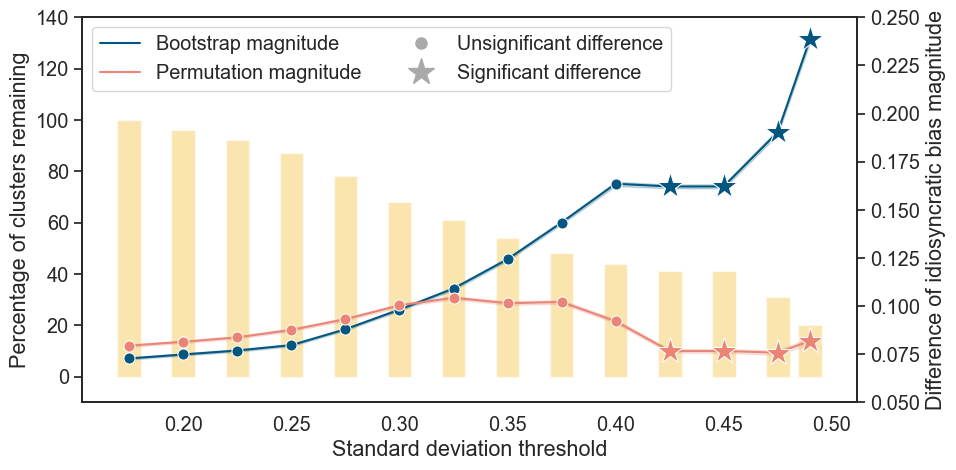

In [48]:
sns.set(font_scale=(1.3))
#sns.set_palette('RdYlBu', n_colors=2)
with sns.axes_style("white"):
#    fig=plt.figure()
    fig, ax1 = plt.subplots(figsize=(10,5))
    #plt.barplot(hist_df, x='std_thresh', y='count', color='#a3d3e6')
    
    ax1.bar(x=hist_df['std_thresh'], height=hist_df['count'], width=0.011, alpha=0.5, color='#F7CD61')#a3d3e6
    ax1.set_ylim([-10, 140])
    ax1.set_ylabel('Percentage of clusters remaining')
    ax2 = ax1.twinx()
    sns.lineplot(data=unsignificant, x="std_threshold", y="idiosyncracy", 
                     hue='type', marker='o', markersize=8, alpha=1, palette=['#03567F', '#EA8576']) #fca55d
    sns.lineplot(data=significant, x="std_threshold", y="idiosyncracy",  palette=['#03567F', '#EA8576'], 
                     hue='type', marker='*', markersize=20, alpha=1)
    #ax2.plot(acc_df["std_thresh"], acc_df["acc"], marker='o', markersize=20, alpha=1)
    
    plt.ylabel('Difference of idiosyncratic bias magnitude')
    ax1.set_xlabel('Standard deviation threshold')
    plt.ylim([0.05, 0.25])
    #positions, labels = plt.xticks()
    #positions[0] = cluster_accuracy['std'].min()
    #positions[-1] = cluster_accuracy['std'].max()
    #ax2.xaxis.set_ticks(positions, labels)
    #print(positions, labels)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles[2] = mlines.Line2D([], [], color='darkgray', marker='o', linestyle='None', markersize=8)
    handles[3] = mlines.Line2D([], [], color='darkgray', marker='*', linestyle='None', markersize=20)
    new_labels = ['Bootstrap magnitude', 'Permutation magnitude', 'Unsignificant difference', 'Significant difference']
    by_label = dict(zip(new_labels, handles))
    plt.legend(by_label.values(), by_label.keys(), ncols=2)
    
    
    plt.savefig("group_test3_bonferroni.svg", bbox_inches='tight', dpi=300)
    plt.show()

In [18]:
from scipy.stats import pearsonr

In [19]:
std_values

[0.49,
 0.475,
 0.45,
 0.425,
 0.4,
 0.375,
 0.35,
 0.325,
 0.3,
 0.275,
 0.25,
 0.225,
 0.2,
 0.175]

In [21]:
dd_plot.query("type=='boot_diff'").std_threshold.values()

0        0.490
1        0.490
2        0.490
3        0.490
4        0.490
         ...  
13995    0.175
13996    0.175
13997    0.175
13998    0.175
13999    0.175
Name: std_threshold, Length: 14000, dtype: float64

In [22]:
dd_plot

,std_threshold,type,idiosyncracy
0,0.490,boot_diff,0.253139
1,0.490,boot_diff,0.298595
2,0.490,boot_diff,0.216503
3,0.490,boot_diff,0.242930
4,0.490,boot_diff,0.271771
...,...,...,...
27995,0.175,perm_diff,0.076787
27996,0.175,perm_diff,0.070673
27997,0.175,perm_diff,0.076007
27998,0.175,perm_diff,0.081541


In [25]:
pearsonr(dd_plot.query("type=='boot_diff'").idiosyncracy.values, dd_plot.query("type=='boot_diff'").std_threshold.values)

PearsonRResult(statistic=0.9071390376862281, pvalue=0.0)

In [93]:
p_values = []
for std_thresh in std_values:
    with open(f'data/exp_iqr_1000it/p_values/p_values_{std_thresh}.json', 'r') as f:
        p_values.append(json.load(f)['3'][0])

In [91]:
from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(p_values, method='bonferroni')

In [106]:
p_adjusted[1][1]

0.014

In [119]:
before = set(cluster_accuracy.query('std >= 0.4').index)

after = set(cluster_accuracy.query('std >= 0.425').index)

In [120]:
len(before)

44

In [121]:
before.difference(after)

{23, 43, 55}

In [123]:
cluster_accuracy.loc[[23,43,55]]

,std
cluster,
23,0.411157
43,0.410871
55,0.409462


## Internal consistency

In [33]:
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import pearsonr, combine_pvalues
#p_adjusted = multipletests(Column6, method='bonferroni')

In [8]:
halves = splitAllParticipants(trials_exp, 0)

In [30]:
correlations = pd.DataFrame(halves.groupby('participant_id').apply(lambda r:pearsonr(r['half1'], r['half2'])))
#correlations.apply(lambda x:x[0])
correlations['corr'] = correlations[0].apply(lambda x:x[0])
correlations['p_val'] = correlations[0].apply(lambda x:x[1])

In [49]:
correlations = pd.DataFrame(halves.query('participant_id in @low_group_ids').groupby('participant_id').apply(lambda r:pearsonr(r['half1'], r['half2'])))
#correlations.apply(lambda x:x[0])
correlations['corr'] = correlations[0].apply(lambda x:x[0])
correlations['p_val'] = correlations[0].apply(lambda x:x[1])

In [50]:
correlations['corr'].mean()

0.5809378939951149

In [51]:
combine_pvalues(correlations.p_val)

SignificanceResult(statistic=2239.094645200334, pvalue=0.0)

In [54]:
all_halves = np.concatenate((halves.query('participant_id in @high_group_ids').half1,
                             halves.query('participant_id in @high_group_ids').half2))
corrs = []
np.random.seed(0)
for it in tqdm(range(1000)):

    np.random.shuffle(all_halves)
    corrs.append(np.corrcoef(all_halves[:len(all_halves)//2], all_halves[len(all_halves)//2:])[0][1])

100%|███████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2609.41it/s]


In [55]:
np.percentile(corrs, 97.5)

0.03070306015315552

In [57]:
import pingouin as pg

In [64]:
cron_data = trials_exp.groupby(['participant_id', 'cluster'])[['accuracy']].mean().reset_index()\
    .pivot(index='participant_id', columns='cluster', values='accuracy')

In [65]:
pg.cronbach_alpha(cron_data)

(0.9456085095761125, array([0.927, 0.961]))